# CSE 5520 Homework 5

"Visualization of Hypothesis Testing and Network"

| | |
|-|-|
| **Student** | Lynn Pepin ('Tristan Pepin')
|              | tmp13009 / 2079724
| **Due date** | 2021 / Oct / 17 (Sun), 11:59PM

This homework is to help you practice with some data visualization fundamentals.
You are expected to use these visualization techniques and others in your final project.
You are required to do this exercise in Python.
All plots/graphs must have titles and x-y coordinate tick labels. 

In [1]:
# Common imports from Python standard libraries
from dataclasses import dataclass
import math

# Common imports from
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy import cluster
from statistics import mean

# Other useful imports for data handling
import networkx as nx

# Useful imports for visualization
import seaborn
import dabest
import pyvis as pv


EPS = 0.0000001
FINAL = True

# Some useful functions
def almost_equal(a,b,eps=EPS):
    return abs(a-b) <= eps

# Code provided from HW4
def stdev(X):
    m = mean(X)
    return math.sqrt(sum((x-m)**2 for x in X) / len(X))

def degreesOfFreedom(X, Y):
    s1 = (stdev(X)**2)
    s2 = (stdev(Y)**2)
    df = (s1 / len(X) + s2 / len(Y))**2 / ((s1 / len(X))**2 / (len(X) - 1) + (s2 / len(Y))**2 /
(len(Y) - 1))
    return(df)

# Part 1: P value in Hypothesis testing


Consider again the gene expression data sets introduced in Homework 3/4.
Your analysis is limited to comparing
the female/male Dementia group and the female/male Non-Dementia group,
using ‘GSE44768_CR_40_54_Combined.csv’.

Your study goal is
to calculate p-values from multiple t-tests and correct p-values
using Benjamini-Hochberg (BH) correction for 2 genes,
LAMP2 and BSN.

In [2]:
alz_df = pd.read_csv("GSE44768_CR_40_54_Combined.csv")
print(alz_df.keys())

f_df = alz_df[
    [alz_df['GSM_ID'][ii][-1] == 'f'
     for ii in range(len(alz_df))
    ]
]

m_df = alz_df[
    [alz_df['GSM_ID'][ii][-1] == 'm'
     for ii in range(len(alz_df))
    ]
]

# now split into alz/no alz
falz_df = f_df[
    [alz_df['GSM_ID'][ii][11] == 'a'
     for ii in range(len(f_df))
    ]
]

fnd_df = f_df[
    [alz_df['GSM_ID'][ii][11] == 'n'
     for ii in range(len(f_df))
    ]
]

malz_df = m_df[
    [alz_df['GSM_ID'][ii][11] == 'a'
     for ii in range(len(m_df))
    ]
]

mnd_df = m_df[
    [alz_df['GSM_ID'][ii][11] == 'n'
     for ii in range(len(m_df))
    ]
]

gene_keys = ["LAMP2", "BSN"]

Index(['GSM_ID', 'XIST', 'TYROBP', 'DOCK2', 'FCER1G', 'GSTA4', 'ABCC2',
       'TIMELESS', 'ACBD5', 'LMAN1', 'KIFAP3', 'PCTK2', 'SNCA', 'RPS27',
       'RPS18', 'PCBP2', 'STIP1', 'HSPA1A', 'DOPEY1', 'ENPP2', 'GAB2', 'TUBB4',
       'ACTG1', 'SLC22A2', 'AGTR1', 'ZIC2', 'TEKT1', 'FANK1', 'HYDIN', 'MED6',
       'SFRS3', 'PPP2R5A', 'RNASE11', 'LAMP2', 'P2RX7', 'MID1IP1', 'GJA1',
       'STON2', 'CST3', 'CREBBP', 'ABCC11', 'MDGA1', 'SNAP91', 'BSN', 'GLS',
       'DTL', 'UBE2C', 'BUB1', 'RFX4', 'DGCR6', 'AQP4', 'MT1M', 'AMPD1',
       'EGR2', 'PDGFB'],
      dtype='object')


## Step 1

Focus on LAMP2.
Your plan is to perform six different hypothesis testings (t-test) for this gene
a) Non-Dementia Female vs. Alzheimer’s Female,
b) Non-Dementia Female vs. NonDementia Male,
c) Non-Dementia Female vs. Alzheimer’s Male,
d) Alzheimer’s Female vs NonDementia Male,
e) Alzheimer’s Female vs Alzheimer’s Male,
f) Non-Dementia Male vs
Alzheimer’s Male. Calculate p-values based on t-test for each case.

Discuss what you can say based on the p-values you got,
assuming the significance level $\alpha$ = 0.05. 

> **Lynn's notes:** The False Discovery Rate is given as (number of 'false discoveries')/(number of discoveries, false and true.)
>
> One can think of a "false discovery" as a false-negative, and a "true discovery" as a "true negative". So, this would be $\frac{\text{TN}}/{\text{TN} + \text{FN}}$.
>
> Replacing 'negative' with 'positive', this is PPV (positive predictive value), i.e. $PPV = 1 - FDR$.
> 
> **Benjamini-Hochberg correction (BH correction)** controls FDR at a level $\alpha$ for ascending $p_i \in P$, where $P$ is of length $m$.:
>
> 1. For a given $\alpha$, find the largest $k$ such that $p_k \leq \frac{k}{m}\alpha$
> 2. Reject the Null Hypothesis for all $H_j$ for $i \in 1, 2, ... k$.
> 
> Remember, rejecting null hypothesis means accepting your Cool Hypothesis.
> 
> **TLDR:** For ascending sorted list $P$ of length $m$, find the largest $k$ where `P[k] <= ka/m`.
>
> **Steps:**
> a) Non-Dementia Female vs. Alzheimer’s Female,
> b) Non-Dementia Female vs. NonDementia Male, 
> c) Non-Dementia Female vs. Alzheimer’s Male, 
> d) Alzheimer’s Female vs NonDementia Male, 
> e) Alzheimer’s Female vs Alzheimer’s Male, 
> f) Non-Dementia Male vs Alzheimer’s Male.




In [3]:
gene_key = 'LAMP2'
alpha = 0.05

def _do_t_test(df, gene_key = 'LAMP2', alpha = 0.05):
    # oops unused, thought this might be useful
    v_obs = degreesOfFreedom(dem_df['LAMP2'], ndem_df['LAMP2'])
    t_obs, p_obs = stats.ttest_ind(df[gene_key], ndem_df[gene_key], equal_var=False)
    
    return p_obs, t_obs, v_obs

pairs_of_gene_dataframes = [
    (fnd_df, falz_df),
    (fnd_df, mnd_df),
    (fnd_df, malz_df),
    (falz_df, mnd_df),
    (falz_df, malz_df),
    (mnd_df, malz_df)
]

over_df = pd.DataFrame(
    # Rebuild the df, indexed by title, for dabest
    {
        'falz' : falz_df['LAMP2'],
        'fnd'  : fnd_df['LAMP2'],
        'malz' : malz_df['LAMP2'],
        'mnd'  : mnd_df['LAMP2']
    }
)

PP = [stats.ttest_ind(left_df[gene_key], right_df[gene_key], equal_var=False)[1]
      for left_df, right_df in pairs_of_gene_dataframes]

for ii in range(len(PP)):
    print(f"Got value {PP[ii]:.3f} for step ({chr(65+ii)})")



Got value 0.001 for step (A)
Got value 0.202 for step (B)
Got value 0.105 for step (C)
Got value 0.016 for step (D)
Got value 0.107 for step (E)
Got value 0.520 for step (F)


The lower the $p$ value is, the more "confident" we are of a statistically significant difference between two groups. This means we should expect a low $p$ for pairs comparing Alzheimers to Non-Alzheimers samples, and a high $p$ between pairs of like.

That is to say, we would expect lowest $p$ for A, C, D, and F. However, surprisingly, $p$ is the *highest* for $F$, by far!

The lowest $p$, corresponding to $A$, shows our metric (expression of `LAMP2`) distinguishes Alzheimers well between samples drawn from female people. But we see the opposite for $F$, i.e. suggesting it cannot distinguish Alzheimers very well between samples drawn from male people.

So, it might be possible that `LAMP2` can be used to help diagnose Alzhimers in female-sex people.

## Step 2

Produce 2x3 plot of 6 Gardner-Altman estimation plots from Step 1 a) ~f).
The first row should include Gardner-Altman estimation plots of a), b) and c),
and the second row GardnerAltman estimation plots of d), e) and f).

/home/lynn/miniconda3/envs/5520/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


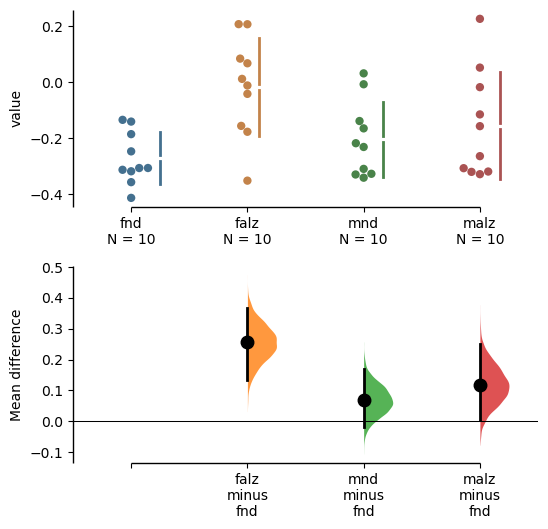

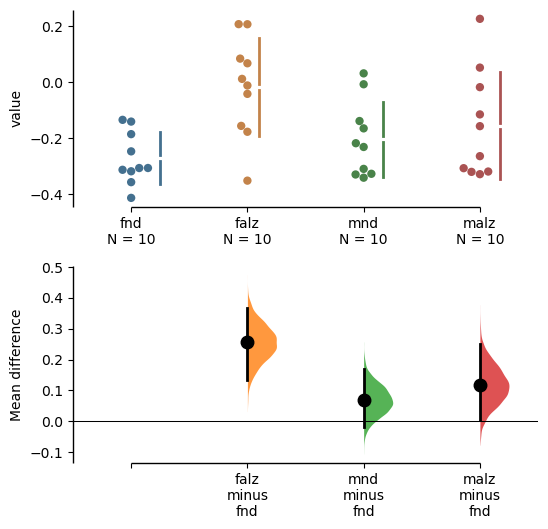

In [4]:
# TODO
#alz_df = basically [f_df, m_df, falz_df, fnd_df, malz_df, mnd_df]

df_dabest = dabest.load(
    data = over_df,
    idx = ['fnd', 'falz', 'mnd', 'malz'],
    
)

df_dabest.mean_diff.plot()

## Step 3

You like to perform Benjamini-Hochberg(BH) correction for the p-values found in Step1

In [5]:

def _bh_find_k(PP, alpha=0.05, debug=True):
    PBH = sorted(PP)
    mm = len(PP)
    
    for kk in list(range(mm))[::-1]:
        if debug: print(f"... P[{kk}] = {PBH[kk]:.4f}")
        
        if PBH[kk] <= (kk+1)*alpha / mm:
            if debug: print(f"... P[{kk}] = {PBH[kk]:.3f} <= {kk+1}*{alpha:.1f} / {mm}")
            
            return kk
    
    if debug: print(f"... No k found! That's rough buddy.")
    
    return -1

kk = _bh_find_k(PP)
print(f"Sorted and using BH, for {gene_key}, we find k = {kk} \n (... er, {kk+1} if you're using it in math.\n   ... {kk} for programming, {kk+1} for math...)")

... P[5] = 0.5196
... P[4] = 0.2022
... P[3] = 0.1071
... P[2] = 0.1045
... P[1] = 0.0156
... P[1] = 0.016 <= 2*0.1 / 6
Sorted and using BH, for LAMP2, we find k = 1 
 (... er, 2 if you're using it in math.
   ... 1 for programming, 2 for math...)


### Step 3 Item (a)

Plot sorted p-values (ascending order) in blue dots. 

### Step 3 Item (b)

Draw a red line with slope $\frac{\alpha}{m}$
on top of the plot a),
where $\alpha$ is the desired FDR (0.05)
and $m$ is total number of comparisons (6).
Your plot should look like the plot give below,
except in your case the range of x axis will be 1 ~ 6 (Note that we have only 6 p-values). 

### Step 3 Item (c)

 Show the largest k that is below the red line. 
 
### Step 3 Item (d)

Show the corresponding $p$-values up to the largest $k$ found in c).

For example,
the largest $k$ that is smaller than the red line is 4,
4 smallest $p$-values should be recognized. 

### Step 3 Item (e)

Plot the found $p$-values with green dots on top of the plot b).

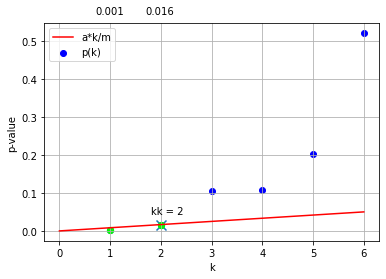

In [6]:
PPi = np.argsort(PP)

Ks = np.linspace(0,6,7,endpoint=True)

# (a) sorted p-values (ascending)
plt.scatter(range(1,7), sorted(PP), color='blue')

# (b) Red line with given slope
plt.plot(Ks, [kk * alpha / len(PP) for kk in Ks], color='red')

# (c) specify largest k
plt.scatter(kk+1, sorted(PP)[kk], marker='x', s=100)
plt.text(kk+1 - .2, sorted(PP)[kk] + .03, f"kk = {kk+1}")

# (d) plotting the corresponding k values
for ii in range(kk+1):
    plt.text(ii+1 - .3, sorted(PP)[-1] + .05, f"{sorted(PP)[ii]:.3f}") #f"p_{kk+1} = {PP[PPi[ii]]:.3f}")

# (e) Plot the found  𝑝-values with green dots on top of the plot b).
plt.scatter(range(1,kk+2), sorted(PP)[:kk+1], marker='o', s=40, c='lime')


# misc 
plt.grid()
plt.ylabel('p-value')
plt.xlabel('k')
plt.legend(["a*k/m", "p(k)"])

## Step 4

Add a Jupyter lab markdown cell to compare the Hierarchical clustering results you did for HW4
with what you have produced in Steps 1, 2, and 3.

Do Hierarchical clustering and Gardner-Altman estimation plots show the similar analysis results?
Do Hierarchical clustering and the raw p-values indicate the similar analysis results?
How about the corrected p-values?
Is there any difference between the p-values and corrected p-values
when you contrast these values with the outcome from Hierarchical clustering?

Please note that your goal is trying to build a  case by showing/contrasting both numerical values and plots
(This course tile is “Data Visualization and Communication”!).

### Step 4 Q1: "Do Hierarchical clustering and Gardner-Altman estimation plots show the similar analysis results?"

> **Answer:** 

### Step 4 Q4: "Is there any difference between the p-values and corrected p-values when you contrast these values with the outcome from Hierarchical clustering?"

> **Answer:** 

### Step 4 Q2: "Do Hierarchical clustering and the raw p-values indicate the similar analysis results?"

> **Answer:** 

### Step 4 Q3: "How about the corrected p-values?"

> **Answer:** 

### Step 4 Q4: "Is there any difference between the p-values and corrected p-values when you contrast these values with the outcome from Hierarchical clustering?"

> **Answer:** 


## Step 5

Repeat Steps1 ~ 4 for the gene BSN.

Got value 0.032 for step (A)
Got value 0.624 for step (B)
Got value 0.706 for step (C)
Got value 0.049 for step (D)
Got value 0.047 for step (E)
Got value 0.918 for step (F)


/home/lynn/miniconda3/envs/5520/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


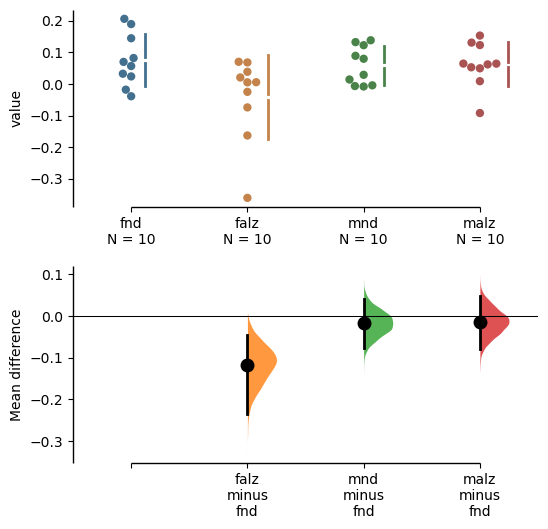

In [11]:
gene_key = 'BSN'
alpha = 0.05

# Defined:
# _do_t_test(df, gene_key = 'LAMP2', alpha = 0.05)
# pairs_of_gene_dataframes
# over_df
# _bh_find_k

def p1steps1thru4(gene_key = 'BSN', plot_GA=False, plot_BH=False):
    # Step 1: P-values
    PP = [stats.ttest_ind(left_df[gene_key], right_df[gene_key], equal_var=False)[1]
          for left_df, right_df in pairs_of_gene_dataframes]
    
    for ii in range(len(PP)):
        print(f"Got value {PP[ii]:.3f} for step ({chr(65+ii)})")
    
    # Step 2: GA Estimation plots
    if plot_GA:
        over_df = pd.DataFrame(
            # Rebuild the df, indexed by title, for dabest
            {   'falz' : falz_df[gene_key],
                'fnd'  : fnd_df[gene_key],
                'malz' : malz_df[gene_key],
                'mnd'  : mnd_df[gene_key]
            }
        )

        df_dabest = dabest.load(
            data = over_df,
            idx = ['fnd', 'falz', 'mnd', 'malz'],

        )

        df_dabest.mean_diff.plot()
    
    # Step 3: BH correction
    if plot_BH:
        kk = _bh_find_k(PP)
        print(f"Sorted and using BH, for {gene_key}, we find k = {kk} \n (... er, {kk+1} if you're using it in math.\n   ... {kk} for programming, {kk+1} for math...)")
        PPi = np.argsort(PP)

        Ks = np.linspace(0,6,7,endpoint=True)

        # (a) sorted p-values (ascending)
        plt.scatter(range(1,7), sorted(PP), color='blue')

        # (b) Red line with given slope
        plt.plot(Ks, [kk * alpha / len(PP) for kk in Ks], color='red')

        # (c) specify largest k
        plt.scatter(kk+1, sorted(PP)[kk], marker='x', s=100)
        plt.text(kk+1 - .2, sorted(PP)[kk] + .03, f"kk = {kk+1}")

        # (d) plotting the corresponding k values
        for ii in range(kk+1):
            plt.text(ii+1 - .3, sorted(PP)[-1] + .05, f"{sorted(PP)[ii]:.3f}") #f"p_{kk+1} = {PP[PPi[ii]]:.3f}")

        # (e) Plot the found  𝑝-values with green dots on top of the plot b).
        plt.scatter(range(1,kk+2), sorted(PP)[:kk+1], marker='o', s=40, c='lime')


        # misc 
        plt.grid()
        plt.ylabel('p-value')
        plt.xlabel('k')
        plt.legend(["a*k/m", "p(k)"])


#p1steps1thru4(plot_GA=True)
p1steps1thru4(plot_GA=True)

Got value 0.032 for step (A)
Got value 0.624 for step (B)
Got value 0.706 for step (C)
Got value 0.049 for step (D)
Got value 0.047 for step (E)
Got value 0.918 for step (F)
... P[5] = 0.9180
... P[4] = 0.7056
... P[3] = 0.6241
... P[2] = 0.0489
... P[1] = 0.0469
... P[0] = 0.0322
... No k found! That's rough buddy.
Sorted and using BH, for BSN, we find k = -1 
 (... er, 0 if you're using it in math.
   ... -1 for programming, 0 for math...)


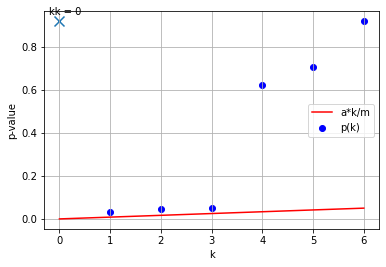

In [13]:
p1steps1thru4(plot_BH=True)

## Step 6 (extra credit)

If you think there is a better gene than LAMP2 or BSN
to contrast various plots in the above steps,
you are welcome to repeat the steps with the gene of your choice.

Hint –
You could use your heatmap you generated in HW4
to select what could provide an interesting case
contrasting different plots
(i.e., genes that can differentiate different patient groups).

---

Heatmap from HW4:

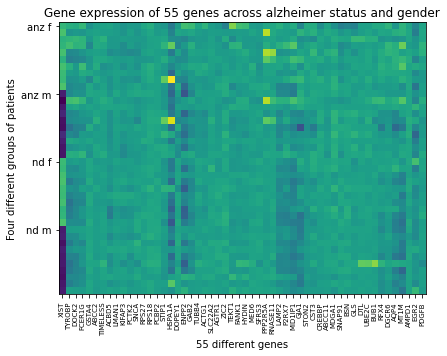



Visually, it seems `PPP2R5A` or `HSPA1A` can be good differentiators. To me, I see the vertical line as four sets of distributions, and whichever seems to have a top half that is most different than the bottom half is the winner. 

So, other candidates include `MT1M` or `P2RX7`.

(TODO: Repeat steps)

In [17]:
alz_df.keys()

Index(['GSM_ID', 'XIST', 'TYROBP', 'DOCK2', 'FCER1G', 'GSTA4', 'ABCC2',
       'TIMELESS', 'ACBD5', 'LMAN1', 'KIFAP3', 'PCTK2', 'SNCA', 'RPS27',
       'RPS18', 'PCBP2', 'STIP1', 'HSPA1A', 'DOPEY1', 'ENPP2', 'GAB2', 'TUBB4',
       'ACTG1', 'SLC22A2', 'AGTR1', 'ZIC2', 'TEKT1', 'FANK1', 'HYDIN', 'MED6',
       'SFRS3', 'PPP2R5A', 'RNASE11', 'LAMP2', 'P2RX7', 'MID1IP1', 'GJA1',
       'STON2', 'CST3', 'CREBBP', 'ABCC11', 'MDGA1', 'SNAP91', 'BSN', 'GLS',
       'DTL', 'UBE2C', 'BUB1', 'RFX4', 'DGCR6', 'AQP4', 'MT1M', 'AMPD1',
       'EGR2', 'PDGFB'],
      dtype='object')

Got value 0.029 for step (A)
Got value 0.321 for step (B)
Got value 0.205 for step (C)
Got value 0.038 for step (D)
Got value 0.340 for step (E)
Got value 0.264 for step (F)


/home/lynn/miniconda3/envs/5520/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


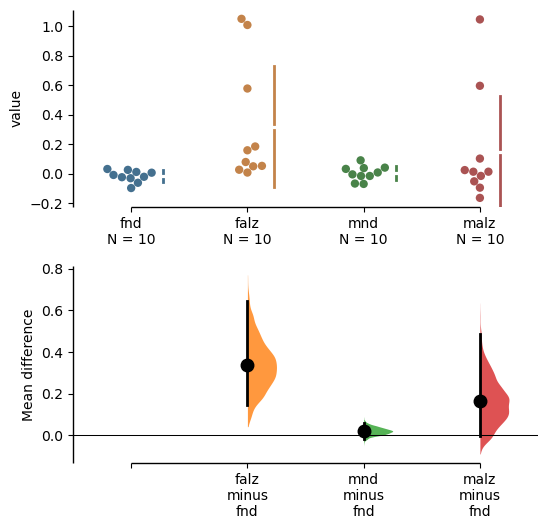

In [21]:
gk = 'PPP2R5A'
p1steps1thru4(gene_key = gk, plot_GA=True)

Got value 0.029 for step (A)
Got value 0.321 for step (B)
Got value 0.205 for step (C)
Got value 0.038 for step (D)
Got value 0.340 for step (E)
Got value 0.264 for step (F)
... P[5] = 0.3398
... P[4] = 0.3215
... P[3] = 0.2641
... P[2] = 0.2053
... P[1] = 0.0375
... P[0] = 0.0288
... No k found! That's rough buddy.
Sorted and using BH, for PPP2R5A, we find k = -1 
 (... er, 0 if you're using it in math.
   ... -1 for programming, 0 for math...)


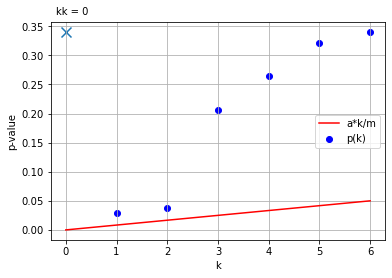

In [22]:

p1steps1thru4(gene_key = gk, plot_BH=True)

Got value 0.000 for step (A)
Got value 0.281 for step (B)
Got value 0.015 for step (C)
Got value 0.000 for step (D)
Got value 0.085 for step (E)
Got value 0.002 for step (F)
... P[5] = 0.2811
... P[4] = 0.0855
... P[3] = 0.0147
... P[3] = 0.015 <= 4*0.1 / 6
Sorted and using BH, for MT1M, we find k = 3 
 (... er, 4 if you're using it in math.
   ... 3 for programming, 4 for math...)


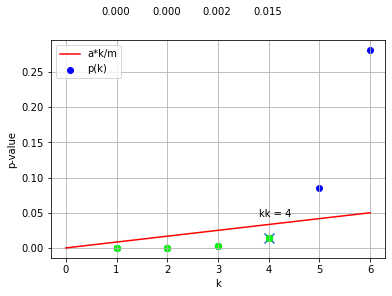

In [23]:
# That one didn't work, how about this one?
gk = 'MT1M'
p1steps1thru4(gene_key = gk, plot_BH=True)

# YES! :)

Got value 0.000 for step (A)
Got value 0.281 for step (B)
Got value 0.015 for step (C)
Got value 0.000 for step (D)
Got value 0.085 for step (E)
Got value 0.002 for step (F)


/home/lynn/miniconda3/envs/5520/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


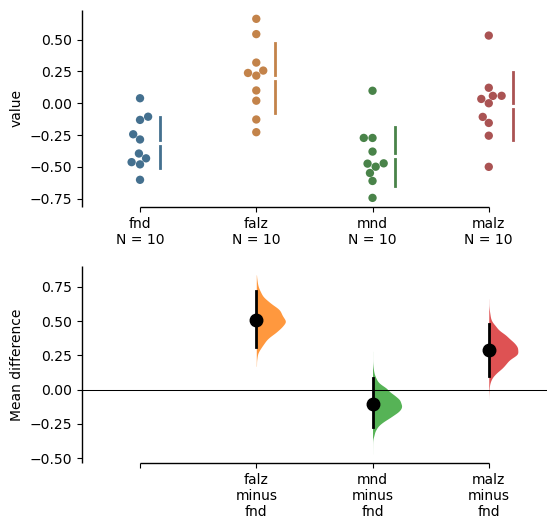

In [24]:

p1steps1thru4(gene_key = gk, plot_GA=True)

---

# Part 2: Network visualization

Consider the Alzheimer data set GSE44768_CR_alz_female_reduced.csv
which is available at HuskyCT’s Data folder.

***... TODO! Your Pearson Indices are wrong! (Many duplicates)***

In [286]:
# use dem_df

dem_df = pd.read_csv('GSE44768_CR_alz_female_reduced.csv')

In [287]:
GENES = dem_df.keys()[10:]
GENES

# he must have meant 54?

Index(['XIST', 'TYROBP', 'DOCK2', 'FCER1G', 'GSTA4', 'ABCC2', 'TIMELESS',
       'ACBD5', 'LMAN1', 'KIFAP3', 'PCTK2', 'SNCA', 'RPS27', 'RPS18', 'PCBP2',
       'STIP1', 'HSPA1A', 'DOPEY1', 'ENPP2', 'GAB2', 'TUBB4', 'ACTG1',
       'SLC22A2', 'AGTR1', 'ZIC2', 'TEKT1', 'FANK1', 'HYDIN', 'MED6', 'SFRS3',
       'PPP2R5A', 'RNASE11', 'LAMP2', 'P2RX7', 'MID1IP1', 'GJA1', 'STON2',
       'CST3', 'CREBBP', 'ABCC11', 'MDGA1', 'SNAP91', 'BSN', 'GLS', 'DTL',
       'UBE2C', 'BUB1', 'RFX4', 'DGCR6', 'AQP4', 'MT1M', 'AMPD1', 'EGR2',
       'PDGFB'],
      dtype='object')

## Step 1

Create and show a 50 x 50 correlation matrix
for pairs of genes for the female Alzheimer’s patients for CR
by appropriately thresholding their Pearson correlation coefficients.

That is, you include top 50 pairs having higher “absolute” correlation coefficient values $|r|$. 

***(NOTE: I am using 54 instead of 50.) I assume '50' was a mistake.***

In [296]:
#pcc = np.corrcoef(Xs, Ys)
#pcc_xy = pcc[0,1]

get_pearson = lambda Xs, Ys: np.corrcoef(Xs, Ys)[0,1]

pearson_matrix = np.array(
    [
        [
            get_pearson(dem_df[gene_key_i], dem_df[gene_key_j])
            for gene_key_i in GENES
        ]
        for gene_key_j in GENES
    ]
)

# https://stackoverflow.com/questions/30577375/
# i always hated unraveling indeices in assembly

pearson_indices = np.array(
    np.unravel_index(
        np.argsort(np.abs(pearson_matrix), axis=None),
        pearson_matrix.shape
    )
).T
    
pearson_indices.shape

(2916, 2)

In [300]:
pearson_indices[:10]

array([[17, 27],
       [27, 17],
       [21,  6],
       [ 6, 21],
       [25,  5],
       [ 5, 25],
       [49,  8],
       [ 8, 49],
       [43, 51],
       [51, 43]])

In [298]:
top_50 = pearson_matrix[tuple(np.array(list(zip(*pearson_indices[::-50]))))]

top_50

array([ 1.        ,  1.        , -0.75292243,  0.69858657,  0.66146331,
       -0.63384102, -0.59871368,  0.57241361, -0.52423962,  0.50040036,
       -0.48662397,  0.47194483,  0.45778704,  0.43433159, -0.40850958,
       -0.38945532,  0.368738  ,  0.35233267,  0.33536856, -0.3174117 ,
        0.30172082, -0.28413306,  0.26949506, -0.25805937, -0.24801474,
       -0.23791073, -0.22596807,  0.21539588,  0.20821709, -0.20001653,
        0.1927595 , -0.18495297, -0.1767008 , -0.16681935, -0.15696189,
        0.15081436, -0.14319555,  0.13541523, -0.12868017,  0.12210539,
       -0.11694821,  0.11078637,  0.10514802,  0.09794446,  0.08961539,
       -0.08501496,  0.07816181, -0.07108357, -0.06643201, -0.06073375,
       -0.05498665,  0.04681978, -0.03932725, -0.03306883,  0.02775394,
       -0.02201004,  0.0160195 ,  0.009091  , -0.00156198])

## Step 2

Use Networkx to turn the correlation matrix of Step 1 into a network of undirected edges.

That is, you try to show how top 50 correlated genes could be interacting with each other.

If $r$ is positive, the edge should be red color, and
if negative, green color,
as illustrated in lecture slide.

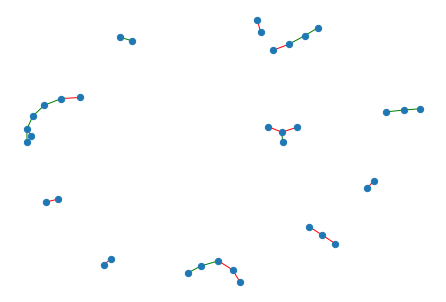

In [299]:
GG = nx.Graph()
GG.add_edges_from(pearson_indices[:50])

edge_colors = ['r' if pearson_matrix[ii,jj] > 0 else 'g' for ii, jj in pearson_indices]

nx.draw(GG, node_size=40, edge_color=edge_colors)

# Note: There are 'duplicate' edges.
# visualize both? how to make them not overlap?
# ... seems no: https://stackoverflow.com/questions/22785849/drawing-multiple-edges-between-two-nodes-with-networkx

## Step 3

This time, use Pyvis to repeat what you have done for Step 2.

In [302]:
NN = pv.network.Network()

# todo: instead of names, 
NN.add_nodes(
    [
        int(index) for index in
        list(
            set.union(
                set(pearson_indices[:,0]),
                set(pearson_indices[:,1])
            )
        )
    ]
)

#NN.add_edges(pearson_indices[:50].tolist())#, color=edge_colors)
# cant add color! let's go one by one

for ii in range(50):
    NN.add_edge(int(pearson_indices[ii, 0]),
                int(pearson_indices[ii, 1]),
                color='#dd0000' if pearson_matrix[tuple(np.array(list(zip(pearson_indices[ii]))))] > 0 else '#00aa00'
               )

#NN.enable_physics(True)
NN.show('mygraph.html')

In [ ]:
# TODO: Screenshot here